In [2]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from bdshare import get_hist_data #library for extracting stock data from DSE and CSE 

In [4]:
stock_data = get_hist_data('2021-04-11','2022-10-30','BEXIMCO') # data after 2022-10-30 has not been updated 
pd.set_option('display.max_rows', None)
print(stock_data.to_string())

             symbol    ltp   high    low   open  close    ycp  trade     value    volume
date                                                                                    
2022-10-30  BEXIMCO  115.6    118  115.6    118  115.6  118.7   3828   539.429   4663899
2022-10-27  BEXIMCO  118.7  120.6  117.5  119.4  118.7  118.9   5550   644.754   5420968
2022-10-26  BEXIMCO  118.9  119.5  116.8  118.9  118.9  117.6   4951   722.063   6096103
2022-10-25  BEXIMCO  117.6  121.3  116.3    119  117.6  119.1   7060   793.731   6669517
2022-10-24  BEXIMCO  119.1    120  116.3    120  119.1  119.1   2794   402.827   3401055
2022-10-23  BEXIMCO  119.1  126.8  117.3  124.7  119.1  123.4   7625   708.776   5765048
2022-10-20  BEXIMCO  123.4  124.4    120    123  123.4  122.2   6415  1170.271   9533334
2022-10-19  BEXIMCO  122.2    126  121.2    124  122.2  122.8   7186   788.367   6375835
2022-10-18  BEXIMCO  122.8  125.6    120  123.3  122.8  123.4   5606   509.178   4128665
2022-10-17  BEXIMCO  

In [5]:
#convert the closing prices to float 
stock = stock_data['close'].astype(float)

In [6]:
#convert the index to datetime
date = pd.to_datetime(stock_data.index)

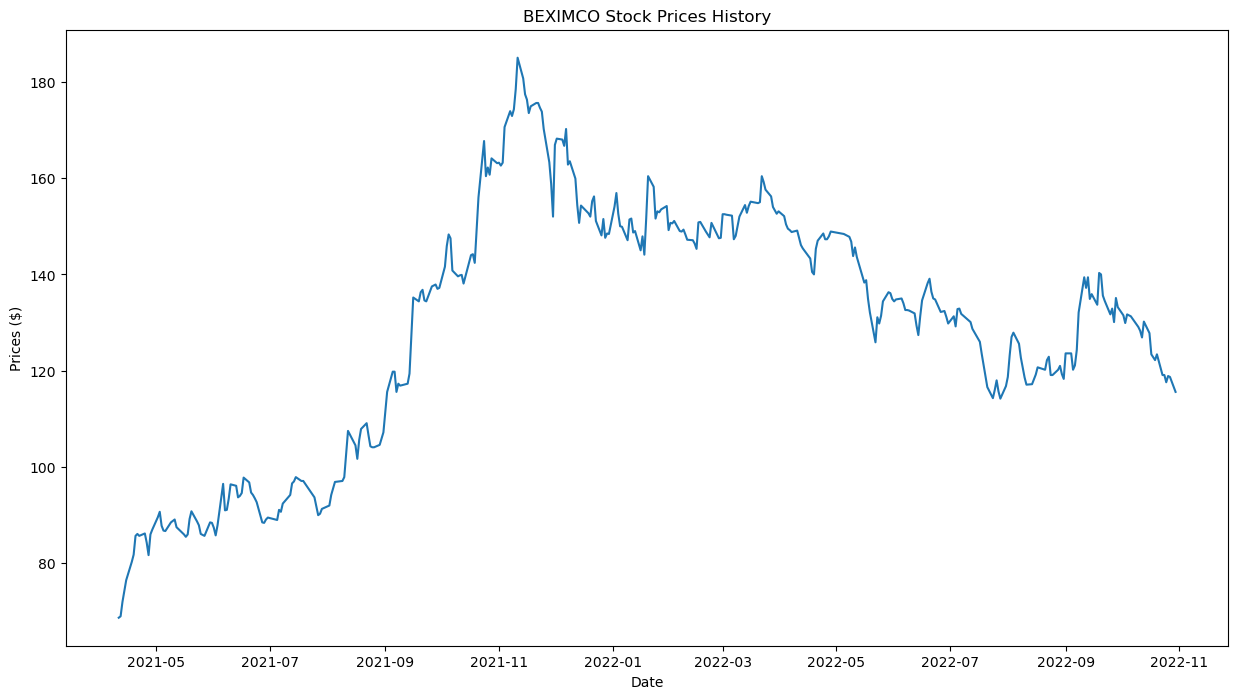

In [85]:
#plot the timeseries for Beximco stock price
plt.figure(figsize=(15, 8))
plt.title('BEXIMCO Stock Prices History')
plt.plot(date, stock)
plt.xlabel('Date')
plt.ylabel('Prices ($)')
#plt.xticks(rotation=45)
#plt.yticks(rotation = 45)
plt.show()

In [16]:
close_prices = stock
values = np.flip(close_prices.values, axis = 0) #there are 380 datapoints in total arranged from 2021 to 2022 
training_data_len = math.ceil(len(values)* 0.8) #will be taking 80% of the dataset (304 datapoints) 

scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_data = scaler.fit_transform(values.reshape(-1,1))

In [31]:
train_data = scaled_data[0: training_data_len, :]#extracting the first 304 datapoints 

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0]) #contains the first 244 datapoints (304-60)
    y_train.append(train_data[i, 0]) #contains the last 244 datapoints 
    #we observe the first 3 months to predict the next 3 months(60 points) 
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # reshaped to dim(240,60,1) 
#(240: our sample size, 60 timesteps: we want the model to look back 60 timesteps to predict the next 60, 
#features: the timesteps are taken from 1 ts data, if we wanted to include the historic data of other 
#ts plots we would increase the features accordingly)

In [38]:
test_data = scaled_data[training_data_len-60: , : ] #contains 136 datapoints 
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0]) #contains 76 datapoints (136-60)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [79]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(120, return_sequences=False))
model.add(layers.Dense(20))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 120)               106080    
                                                                 
 dense_2 (Dense)             (None, 20)                2420      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 149,321
Trainable params: 149,321
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
240/240 [==============================] - 5s 13ms/step - loss: 0.0088
Epoch 2/3
240/240 [==============================] - 3s 13ms/step - loss: 0.0047
Epoch 3/3
240/240 [==============================] - 3s 13ms/step - loss: 0.0031


In [81]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

3/3 [==============================] - 1s 14ms/step


2.5735781695391666

In [82]:
data = pd.DataFrame(stock_data.loc[:, 'close'].iloc[::-1]) #need to flip the dataframe and arrange from 2021 to 2022
#data = stock_data.filter(['close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['predictions'] = predictions

C:\Users\Mir Info\AppData\Local\Temp\ipykernel_444\4161207085.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['predictions'] = predictions


C:\Users\Mir Info\AppData\Local\Temp\ipykernel_444\931587294.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['close'] = validation['close'].astype(float)
C:\Users\Mir Info\AppData\Local\Temp\ipykernel_444\931587294.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['predictions'] = validation['predictions'].astype(float)


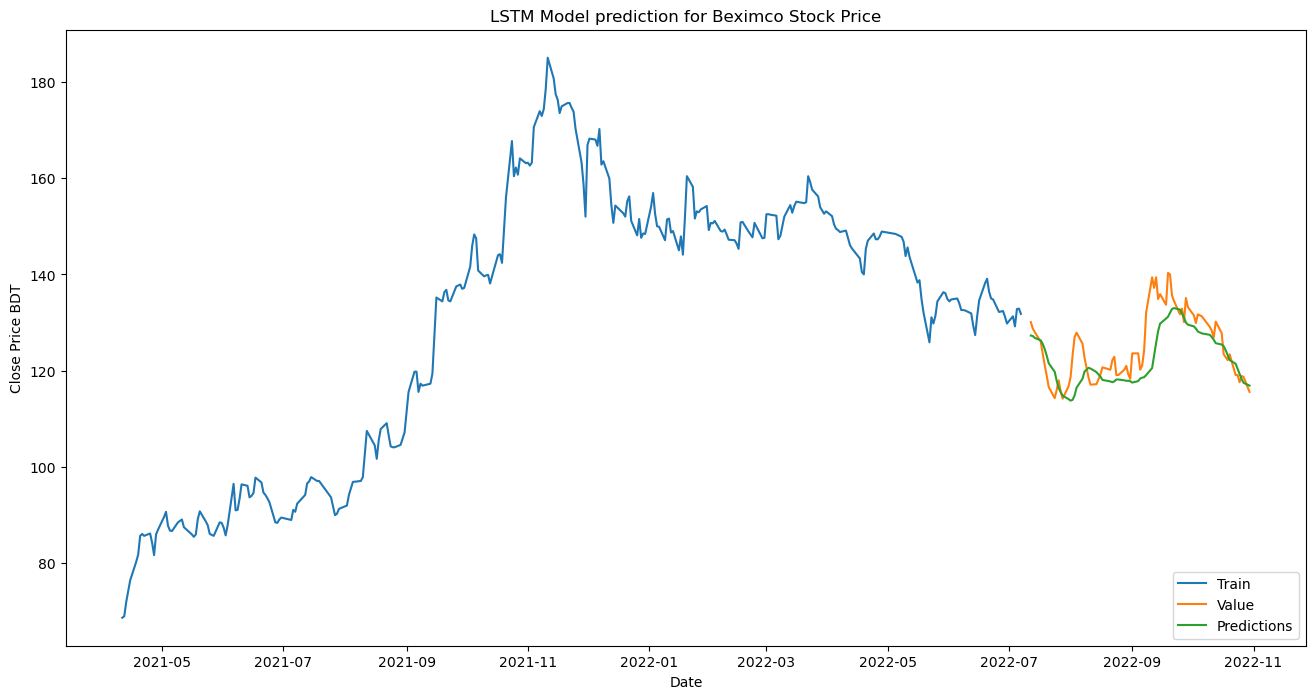

In [83]:
plt.figure(figsize=(16,8))
plt.title('LSTM Model prediction for Beximco Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price BDT')

#convert the closing prices to float 
trainstock = train['close'].astype(float)
#convert the index to datetime 
traindate = pd.to_datetime(train.index)
plt.plot(traindate, trainstock)

validdate = pd.to_datetime(validation.index)
close = validation['close'].astype(float)
pred = validation['predictions'].astype(float)
validation['close'] = validation['close'].astype(float)
validation['predictions'] = validation['predictions'].astype(float)
plt.plot(validdate, validation[['close', 'predictions']])
plt.legend(['Train', 'Value', 'Predictions'], loc='lower right')
plt.show()

In [84]:
pd.set_option('display.max_rows', None)
print(validation)

            close  predictions
date                          
2022-07-12  130.1   127.309479
2022-07-13  128.7   127.184601
2022-07-14  128.0   126.814629
2022-07-17  126.0   126.297440
2022-07-18  123.5   125.537651
2022-07-19  121.1   124.467934
2022-07-20  118.9   123.109238
2022-07-21  116.6   121.531219
2022-07-24  114.3   119.782715
2022-07-25  116.0   117.910492
2022-07-26  118.0   116.427162
2022-07-27  115.7   115.553596
2022-07-28  114.2   114.818802
2022-07-31  116.8   114.091003
2022-08-01  118.7   113.782875
2022-08-02  123.2   113.944839
2022-08-03  127.0   114.857491
2022-08-04  127.9   116.473732
2022-08-07  125.6   118.338898
2022-08-08  122.7   119.822449
2022-08-10  118.6   120.599838
2022-08-11  117.1   120.455055
2022-08-14  117.2   119.711555
2022-08-16  119.2   118.775673
2022-08-17  120.7   118.088806
2022-08-21  120.2   117.771683
2022-08-22  122.2   117.607597
2022-08-23  122.9   117.781273
2022-08-24  119.1   118.175293
2022-08-25  119.1   118.175430
2022-08-